# Modeling the Kinetic Molecular Theory of Gases

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.text import Text
import matplotlib.path as path
import matplotlib.patches as patches
from matplotlib import animation, rc
from IPython.display import HTML, Image
from balls_in_box import ParticleBox

## Defining the Kinetic Molecular Theory

[KMT](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Physical_Properties_of_Matter/States_of_Matter/Properties_of_Gases/Kinetic_Theory_of_Gases/Basics_of_Kinetic_Molecular_Theory) is a model for an idealized gas that makes 5 basic assumptions about an ideal gas:

1. The volume of molecules is negligible.
2. There are no attractive forces between molecules.
3. The molecules move in straight lines unless they collide with container walls or each other.
4. Collisions are elastil (KE is conserved)
5. The average kinetic energy of the molecules is proportional to absolute temperature.

From these 5 assumptions which are fairly accurate at low pressure and normal temperatures, familiar laws like the ideal gas law, $PV = nRT$, can be derived. In addition, we can derive the Maxwell-Boltzmann Distribution for the molecular velocities

![Maxwell-Boltzmann](../../images/MB.svg)

And from this distribution, we derive the formula for the root mean square speed of an ideal gas 

$$v_{rms} = \sqrt{\frac{3RT}{M}}$$

and the average kinetic energy of the gas molecules

$$ KE_{avg} = \frac{3}{2}RT$$


## Plotting The Maxwell-Boltzmann Distribution
Below we plot the MB distribution for molecular speeds for a variety of temperatures and molecular weights. It is clear from the graphs that increasing temperature and or decreasing molecular mass broadens the distribution, resulting in more molecules moving at high speeds.

We also show here that the boltzmann distribution for the speeds comes from velocities that are normally distributed with a standard deviation of $\sqrt{\frac{k_bT}{m}}$. If `add_samples` is set to `True`, then the chosen number of samples will be drawn from this distribution for each velocity component of the molecule (2 components since we treat the 2-D case here), and the speed will is calculated as the norm of the velocity. This distribution of sampled speeds is plotted as a histogram, and it clearly matches the PDF for the corresponding molecular species.

First define some user inputs.

In [25]:
add_samples = True
samp_size = 1000
cmax = 2000

Then plot, and sample the normal distribution if desired!

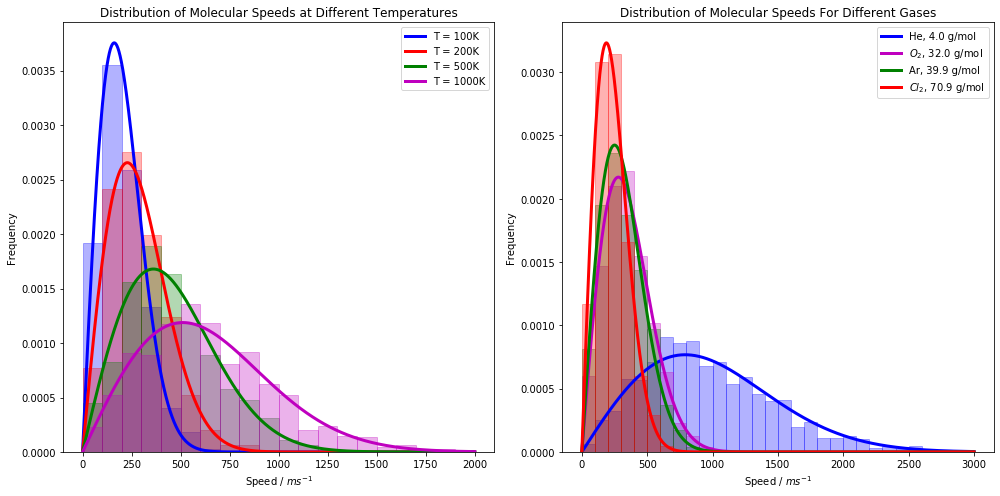

In [26]:
kb = 3.175E-6  # Hartree atomic units
c = np.linspace(0, cmax, cmax * 10)
c_conv = 2.188E6  # multiply by au to get m/s
c_au = c / c_conv

fig = plt.figure(figsize=(14, 7))

# plot of distribution at different temperatures
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Distribution of Molecular Speeds at Different Temperatures')
ax1.set_xlabel('Speed / $ms^{-1}$')
ax1.set_ylabel('Frequency')
m = 58240  # mass of O2 in Hartree au
binstep = 100
bins = np.arange(0, (cmax+binstep) / c_conv, binstep / c_conv)
colors = 'b r g m'.split()
for i, T in enumerate([100, 200, 500, 1000]):
    pdf = m * c_au / (kb * T) * np.exp(-m * c_au ** 2 / (2 * kb * T))
    # normalize the pdf
    pdf = pdf / np.trapz(pdf, c)
    ax1.plot(c, pdf, f'{colors[i]}-', linewidth=3, label=f'T = {T}K')
    
    if add_samples:
        c_samp = np.linalg.norm(np.random.normal(loc=0, scale=np.sqrt(kb * T / m), size=(samp_size, 2)), axis=1)
        freq, edges = np.histogram(c_samp, bins)
        edges = c_conv * edges
        freq = freq / np.sum(freq) / binstep  # normalize the counts to sum to 1
        ax1.bar(edges[:-1], freq, width=np.diff(edges), ec=f"{colors[i]}", fc=f'{colors[i]}', alpha=0.3, align="edge")
ax1.legend()

# plot of distribution for different gases at 300K
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Distribution of Molecular Speeds For Different Gases')
ax2.set_xlabel('Speed / $ms^{-1}$')
ax2.set_ylabel('Frequency')
cmax *= 1.5
c = np.linspace(0, cmax, cmax * 10)
c_au = c / c_conv
bins = np.arange(0, (cmax+binstep) / c_conv, binstep / c_conv)
gases = ['He', '$O_2$', 'Ar', '$Cl_2$']
m_conv = 0.001 / 6.02E23 / 9.1E-31
masses = list(m_conv * np.array([4, 32, 39.9, 70.9]))
T = 300
for i, gas in enumerate(zip(gases, masses)):
    name, m = gas
    pdf = m * c_au / (kb * T) * np.exp(-m * c_au ** 2 / (2 * kb * T))
    # normalize the pdf
    pdf = pdf / np.trapz(pdf, c)
    ax2.plot(c, pdf, f'{colors[-i]}-', linewidth=3, label=f'{name}, {m / m_conv} g/mol')
    
    if add_samples:
        c_samp = np.linalg.norm(np.random.normal(loc=0, scale=np.sqrt(kb * T / m), size=(samp_size, 2)), axis=1)
        freq, edges = np.histogram(c_samp, bins)
        edges = c_conv * edges
        freq = freq / np.sum(freq) / binstep # normalize the counts to sum to 1
        ax2.bar(edges[:-1], freq, width=np.diff(edges), ec=f"{colors[-i]}", fc=f'{colors[-i]}', alpha=0.3, align="edge")
ax2.legend()

plt.tight_layout()
plt.show()

### Simulation

Besides deriving these quantities analytically, it can be fun and informative to see how they evolve naturally from the 5 assumptions listed above via a simulation. In this notebook, we model an ideal gas in 2D, with molecules being small circles that undergo completely elastic conditions with themselves and their container. From the simulation, which was adapted from this [animation tutorial](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/) by Jake Vanderplas, we calculate the distribution of particle speeds to show that it does, in fact, follow the Maxwell-Boltzmann distribution derived analytically. The idea for this came from this [gif](https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution#/media/File:Simulation_of_gas_for_relaxation_demonstration.gif) on wikipedia!

# Relaxation of Speeds to Maxwell-Boltzmann Distribution

We initialize our Particle Box with 900 particles with normally-distributed speeds and watch how in time the normal distribution relaxes to the predicted Maxwell-Boltzmann one.

First, we define our constants and some simulation parameters and then we let the sim go. Since the simulation takes place in 2D, the MB distribution for speeds changes slightly to:

$$f(v)dv = \frac{mv}{k_bT}e^{\frac{-mv^2}{2k_bT}}dv$$

Similarly, the calculation for the mean Kinetic Energy in 2-D changes to 

$$KE_{avg} = RT$$

meaning that we can calculate the temperature of our simulation cell as

$$T = \frac{KE_{avg}}{R} = \frac{\frac{1}{2}mv_{rms}}{R}$$

We measure the molecular speed distribution at each time step of our simulation and update a histogram with the values. Over time, that histogram converges to the 2-D MB distribution defined above.

We color several molecules red, just to make it easier to follow an individual molecule during the simulation and see that it is in fact undergoing elastic collisions.

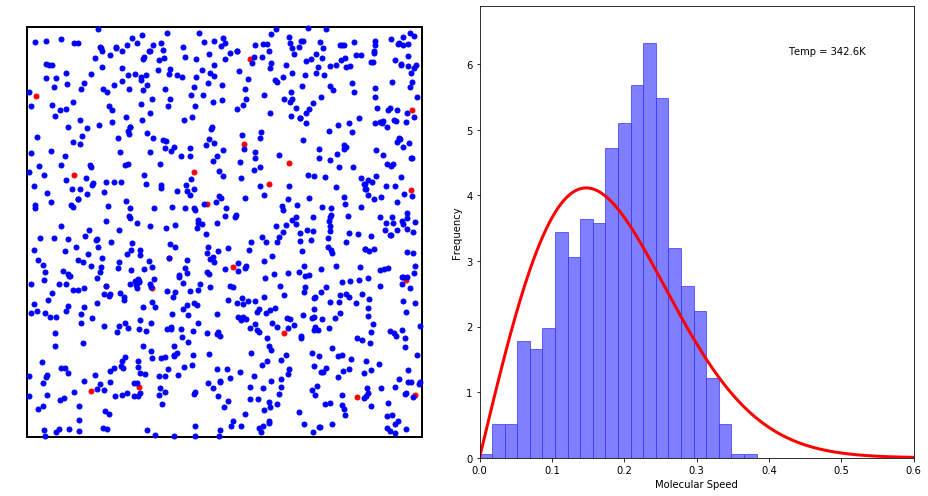

In [12]:
#################################################################################################################
# USER INPUT
# Constants
kb = 3.17E-6  # Hartree atomic units
R = 3.17E-6  # ideal gas constant in Eh/K/molecule

# Parameters
m=0.05  # mass of particles (all same)
cmax = 0.6  # maximum speed to plot on histogram
r = 0.02  # radius of particles
s = 6.0  # width of the simulation box
np.random.seed(0)
init_state = -0.5 + np.random.random((900, 4))  # intialize 900 random positions and velocities
init_state[:, 2:] *= 0.5  # Scale velocities - change scaling term and see how calulated T changes
dt = 1. / 30  # 30fps
##################################################################################################################


bounds=[-s/2, s/2, -s/2, s/2]
init_state[:, :2] *= (s - 2*r)
box = ParticleBox(init_state, size=r, M=m, bounds=bounds)

# set up figure and animation
fig = plt.figure(figsize=(13, 7))

# axis for displaying the particles
ax1 = fig.add_subplot(121, autoscale_on=False, xlim=(-1.1*s/2, 1.1*s/2), ylim=(-1.1*s/2, 1.1*s/2))
ax1.axis('off')

ms = int(fig.dpi * 2 * r * fig.get_figwidth() / np.diff(ax1.get_xbound())[0])

# axis for displaying the histogram of speeds
ax2 = fig.add_subplot(122, autoscale_on=False)
ax2.set_xlim([0,cmax])
ax2.set_xlabel('Molecular Speed')
ax2.set_ylabel('Frequency')
cs = np.linalg.norm(box.state[:, 2:], axis=1)  # particle speeds

# histogram our data with numpy
nbins = 30
bins = np.arange(0, 1.5 * max(cs), 1.5 * max(cs) / nbins)
n, bins = np.histogram(cs, bins, density=True)

# get the corners of the rectangles for the histogram
left = np.array(bins[:-1])
right = np.array(bins[1:])
bottom = np.zeros(len(left))
top = bottom + n
nrects = len(left)
nverts = nrects * (1 + 3 + 1)
verts = np.zeros((nverts, 2))
codes = np.ones(nverts, int) * path.Path.LINETO
codes[0::5] = path.Path.MOVETO
codes[4::5] = path.Path.CLOSEPOLY
verts[0::5, 0] = left
verts[0::5, 1] = bottom
verts[1::5, 0] = left
verts[1::5, 1] = top
verts[2::5, 0] = right
verts[2::5, 1] = top
verts[3::5, 0] = right
verts[3::5, 1] = bottom

# Draw the Patch for the Histogram
barpath = path.Path(verts, codes)
patch = patches.PathPatch(barpath, facecolor='blue', edgecolor='blue', alpha=0.5)
ax2.add_patch(patch)
ax2.set_ylim(0, 1.1 * max(n))

# add text for temp
urms = np.sqrt(np.mean(cs**2))
T_m = np.mean(0.5 * m * cs**2) / R
text = ax2.text(0.8, 0.9, f'Temp = {T_m:.1f}K', horizontalalignment='center',
                verticalalignment='center', transform=ax2.transAxes)
c_au = np.linspace(0, cmax, 500)
pdf = m * c_au / (kb * T_m) * np.exp(-m * c_au ** 2 / (2 * kb * T_m))
mb, = ax2.plot(c_au, pdf, f'r-', linewidth=3, label=f'T = {T_m}K')

# particles holds the locations of the particles
particles_r, = ax1.plot([], [], 'ro', ms=ms)
particles, = ax1.plot([], [], 'bo', ms=ms)

# rect is the box edge
rect = plt.Rectangle(box.bounds[::2], box.bounds[1] - box.bounds[0],  box.bounds[3] - box.bounds[2],
                     ec='k', lw=2, fc='none')
ax1.add_patch(rect)


def animate(i):
    global bins
    """perform animation step"""
    global box, dt, ax1, fig, particles
    box.step(dt)

    # update pieces of the animation
    particles_r.set_data(box.state[:20, 0], box.state[:20, 1])
    particles.set_data(box.state[20:, 0], box.state[20:, 1])
    
    if i % 10 == 0:
        # update velocity histogram
        cs = np.linalg.norm(box.state[:, 2:], axis=1)  # particle speeds
        n, bins = np.histogram(cs, bins, density=True)
        #freq, _, hist = ax2.hist(cs, bins=bins, density=True, ec='b', fc='b', alpha=0.4)
        top = n
        verts[1::5, 1] = top
        verts[2::5, 1] = top

        # get temperature
        urms = np.sqrt(np.mean(cs**2))
        T_m = np.mean(0.5 * m * cs**2) / R
        text.set_text(f'Temp = {T_m:.1f}K')

        ymin, ymax = ax2.get_ylim()
        if np.max(n) >= ymax:
            ax2.set_ylim(ymin, np.max(n) * 1.1)
            ax2.figure.canvas.draw()
    return [particles, rect, mb, patch, text]

plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=700,
                              interval=10, blit=True)

In [13]:
HTML(ani.to_html5_video())

In [14]:
# save the animation as a gif
#rcParams['animation.convert_path'] = r'/usr/bin/convert'
#ani.save('particle_speeds.gif', writer='imagemagick')
# ani.save('particle_speeds_12.mp4', extra_args=['-vcodec', 'libx264'])

# Diffusion of 2 Gases of Different Masses

Here we model diffusion for two gases, a light one and a heavy one. From Graham's Law, we know that the heavier molecules should diffuse (i.e. fill the box) more slowly than the light ones according to

$$\frac{Rate_1}{Rate_2} = \sqrt{\frac{M_2}{M_1}}$$

First we define the relative masses and radii we want for our molecules

In [15]:
s = 6.0  # simulation box width
n1 = 100  # number of molecules of type 1
n2 = 100  # number of molecules of type 2
T = 300   # temperature
m1 = 0.02  # mass of molecule 1
m2 = 0.04  # mass of molecule 2
r1 = 0.04  # radius of molecule 1
r2 = 0.06  # radius of molecule 2

dt = 1. / 30  # simulation time step

Now initialize the molecules in opposite halves of the simulation box with velocities distributed according to the Maxwell-Boltzmann distribution and let 'em go!

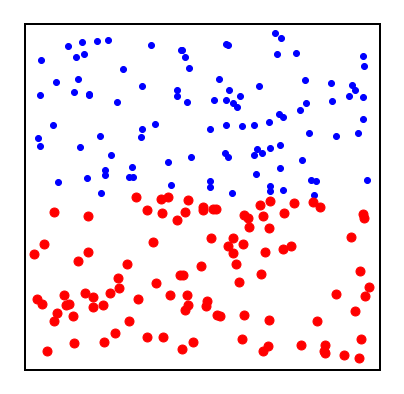

In [16]:
bounds=[-s/2, s/2, -s/2, s/2]
np.random.seed(0)
# start 100 blue particles in the top half
init_posb = np.random.random((n1, 2))
init_posb[:, 0] -= 0.5
init_posb[:, 0] *= 0.95 * s
init_posb[:, 1] *= 0.95 * s / 2
# initialize velocities with correct MB distribution
init_vb = np.random.normal(loc=0, scale=np.sqrt(kb * T / m1), size=(n1, 2))
init_stateb = np.concatenate([init_posb, init_vb], axis=1)
m1s = m1 * np.ones(n1)
rs1 = r1 * np.ones(n1)

# start 100 red particles in the bottom half
init_posr = np.random.random((n2, 2))
init_posr[:, 1] -= 1
init_posr[:, 1] *= 0.95 * s / 2
init_posr[:, 0] -= 0.5
init_posr[:, 0] *= 0.95 * s
init_vr = np.random.normal(loc=0, scale=np.sqrt(kb * T / m2), size=(n2, 2))
init_stater = np.concatenate([init_posr, init_vr], axis=1)
m2s = m2 * np.ones(n2)
rs2 = r2 * np.ones(n2)

r = np.concatenate([rs1,rs2])
m = np.concatenate([m1s,m2s])
init_state = np.concatenate([init_stateb, init_stater])

box = ParticleBox(init_state, size=r, M=m, bounds=bounds)

# set up figure and animation
fig = plt.figure(figsize=(7, 7))

# axis for displaying the particles
ax1 = fig.add_subplot(111, autoscale_on=False, xlim=(-1.1*s/2, 1.1*s/2), ylim=(-1.1*s/2, 1.1*s/2))
ax1.axis('off')

ms1 = int(fig.dpi * 2 * r1 * fig.get_figwidth() / np.diff(ax1.get_xbound())[0])

ms2 = int(fig.dpi * 2 * r2 * fig.get_figwidth() / np.diff(ax1.get_xbound())[0])

# particles holds the locations of the particles
parts1, = ax1.plot(box.state[:n1, 0], box.state[:n1, 1], 'bo', ms=ms1)
parts2, = ax1.plot(box.state[n1:, 0], box.state[n1:, 1], 'ro', ms=ms2)

# rect is the box edge
rect = plt.Rectangle(box.bounds[::2], box.bounds[1] - box.bounds[0],  box.bounds[3] - box.bounds[2],
                     ec='k', lw=2, fc='none')
ax1.add_patch(rect)


def animate(i):
    """perform animation step"""
    box.step(dt)

    # update pieces of the animation
    parts1.set_data(box.state[:n1, 0], box.state[:n1, 1])
    parts2.set_data(box.state[n1:, 0], box.state[n1:, 1])
    
    return [particles, rect, mb, patch, text]


ani2 = animation.FuncAnimation(fig, animate, frames=1000, interval=10, blit=True)

In [17]:
HTML(ani2.to_html5_video())

In [31]:
# ani2.save('diffusion.mp4', extra_args=['-vcodec', 'libx264'])
# ani2.save('diffusion.gif', writer='imagemagick')